In [46]:
print("hi")

hi


In [47]:
# Cell 1: Imports

import os
import xml.etree.ElementTree as ET
from faker import Faker
import pandas as pd
import random
import json

# Initialize Faker for reproducibility
fake = Faker()
Faker.seed(42)

In [48]:
# Cell 2: Generate synthetic crime report data
def generate_crime_report(n_reports=10):
    crime_types = ['Burglary', 'Robbery', 'Assault', 'Theft', 'Vandalism']
    data = {
        'IncidentID': [f'INC-{i:04d}' for i in range(1, n_reports + 1)],
        'Date': [fake.date_time_this_year().strftime('%Y-%m-%dT%H:%M:%S') for _ in range(n_reports)],
        'CrimeType': [random.choice(crime_types) for _ in range(n_reports)],
        'Location': [fake.address().replace('\n', ', ') for _ in range(n_reports)],
        'Latitude': [fake.latitude() for _ in range(n_reports)],
        'Longitude': [fake.longitude() for _ in range(n_reports)],
        'VictimName': [fake.name() for _ in range(n_reports)],
        'VictimAge': [random.randint(18, 80) for _ in range(n_reports)],
        'SuspectName': [fake.name() for _ in range(n_reports)],
        'SuspectAge': [random.randint(18, 80) for _ in range(n_reports)],
        'Description': [fake.sentence(nb_words=10) for _ in range(n_reports)]
    }
    return pd.DataFrame(data)

# Generate 10 synthetic crime reports
df = generate_crime_report(10)
df.head()  # Display sample

,IncidentID,Date,CrimeType,Location,Latitude,Longitude,VictimName,VictimAge,SuspectName,SuspectAge,Description
0,INC-0001,2025-05-05T03:56:41,Assault,"600 Jeffery Parkways, New Jamesside, MT 29394",-36.0039225,-59.366535,Mark Perez,79,Donald Wright,39,Often my security arm once me.
1,INC-0002,2025-01-22T14:50:25,Burglary,"26542 Susan Junction Apt. 161, Melanieview, AS...",-6.3242945,-145.626357,Shannon Jones,44,Jessica Callahan,20,Church whether bag control organization push d...
2,INC-0003,2025-01-05T20:33:30,Vandalism,"1849 Ray Squares, North Donnaport, CO 31013",17.1036795,1.508307,Michael Lewis,27,Amber Kidd,74,Price north first end prove fire enter capital...
3,INC-0004,2025-05-24T23:52:32,Robbery,"7525 Clark Grove Apt. 928, East Steven, KY 84387",84.4503125,-168.707317,Timothy Duncan,33,Tracy House,27,Act perform none beyond Mrs media.
4,INC-0005,2025-02-23T09:43:46,Theft,"503 Linda Locks, Carlshire, FM 94599",10.239303,135.845836,Richard Aguirre,30,Carol Tucker,59,Value thing these hard citizen street region.


In [49]:
# Cell 3: Generate XML for synthetic data without NIEM validation
def create_niem_xml(df, output_dir='synthetic_output', output_file='crime_reports.xml'):
    os.makedirs(output_dir, exist_ok=True)
    
    # Use IncidentCollection as root element without schema references
    root = ET.Element('IncidentCollection', {
        'xmlns:nc': 'http://release.niem.gov/niem/niem-core/5.0/',
        'xmlns:j': 'http://release.niem.gov/niem/domains/jxdm/6.0/',
        'xmlns:s': 'http://release.niem.gov/niem/structures/5.0/'
    })

    for _, row in df.iterrows():
        incident = ET.SubElement(root, 'nc:Incident', {'s:id': escape_xml_text(row['IncidentID'])})
        incident_id = ET.SubElement(incident, 'nc:ActivityIdentification')
        id_elem = ET.SubElement(incident_id, 'nc:IdentificationID')
        id_elem.text = escape_xml_text(row['IncidentID'])
        
        date = ET.SubElement(incident, 'nc:ActivityDate')
        date_time = ET.SubElement(date, 'nc:DateTime')
        date_time.text = escape_xml_text(row['Date'])
        
        category = ET.SubElement(incident, 'nc:ActivityCategoryText')
        category.text = escape_xml_text(row['CrimeType'])
        
        location = ET.SubElement(incident, 'nc:Location')
        address = ET.SubElement(location, 'nc:AddressFullText')
        address.text = escape_xml_text(row['Location'])
        geo = ET.SubElement(location, 'nc:Location2DGeospatialCoordinate')
        lat = ET.SubElement(geo, 'nc:GeographicCoordinateLatitude')
        lat.text = str(row['Latitude'])
        lon = ET.SubElement(geo, 'nc:GeographicCoordinateLongitude')
        lon.text = str(row['Longitude'])
        
        victim = ET.SubElement(incident, 'nc:Person', {'s:id': f"victim-{escape_xml_text(row['IncidentID'])}"})
        victim_name = ET.SubElement(victim, 'nc:PersonName')
        full_name = ET.SubElement(victim_name, 'nc:PersonFullName')
        full_name.text = escape_xml_text(row['VictimName'])
        victim_age = ET.SubElement(victim, 'nc:PersonAgeMeasure')
        age = ET.SubElement(victim_age, 'nc:MeasureValueText')
        age.text = str(row['VictimAge'])
        
        victim_assoc = ET.SubElement(incident, 'nc:ActivityInvolvedPersonAssociation')
        victim_person_ref = ET.SubElement(victim_assoc, 'nc:PersonReference', {'s:ref': f"victim-{escape_xml_text(row['IncidentID'])}"})
        victim_role = ET.SubElement(victim_assoc, 'nc:PersonActivityInvolvementText')
        victim_role.text = 'Victim'
        
        suspect = ET.SubElement(incident, 'nc:Person', {'s:id': f"suspect-{escape_xml_text(row['IncidentID'])}"})
        suspect_name = ET.SubElement(suspect, 'nc:PersonName')
        suspect_full_name = ET.SubElement(suspect_name, 'nc:PersonFullName')
        suspect_full_name.text = escape_xml_text(row['SuspectName'])
        suspect_age = ET.SubElement(suspect, 'nc:PersonAgeMeasure')
        suspect_age_value = ET.SubElement(suspect_age, 'nc:MeasureValueText')
        suspect_age_value.text = str(row['SuspectAge'])
        
        suspect_assoc = ET.SubElement(incident, 'nc:ActivityInvolvedPersonAssociation')
        suspect_person_ref = ET.SubElement(suspect_assoc, 'nc:PersonReference', {'s:ref': f"suspect-{escape_xml_text(row['IncidentID'])}"})
        suspect_role = ET.SubElement(suspect_assoc, 'nc:PersonActivityInvolvementText')
        suspect_role.text = 'Suspect'
        
        desc = ET.SubElement(incident, 'nc:ActivityDescriptionText')
        desc.text = escape_xml_text(row['Description'])
        
        reporting_official = ET.SubElement(incident, 'j:IncidentReportingOfficial')
        official_person = ET.SubElement(reporting_official, 'nc:Person', {'s:id': f"officer-{escape_xml_text(row['IncidentID'])}"})
        official_name = ET.SubElement(official_person, 'nc:PersonName')
        official_full_name = ET.SubElement(official_name, 'nc:PersonFullName')
        official_full_name.text = escape_xml_text(fake.name())
    
    output_path = os.path.join(output_dir, output_file)
    tree = ET.ElementTree(root)
    tree.write(output_path, encoding='utf-8', xml_declaration=True)
    print(f"XML file saved as {output_path}")

create_niem_xml(df)


XML file saved as synthetic_output\crime_reports.xml


In [50]:
# Cell 4: Check XML well-formedness (no schema validation)
def validate_xml(xml_file):
    try:
        ET.parse(xml_file)
        print(f"{xml_file} is well-formed XML.")
    except ET.ParseError as e:
        print(f"XML parsing error in {xml_file}: {e}")

xml_files = [os.path.join('synthetic_output', 'crime_reports.xml')] + [
    os.path.join('niem_chicago_output', f) for f in os.listdir('niem_chicago_output') if f.endswith('.xml')
]
for xml_file in xml_files:
    if os.path.exists(xml_file):
        validate_xml(xml_file)
    else:
        print(f"Error: {xml_file} not found.")
        


synthetic_output\crime_reports.xml is well-formed XML.
niem_chicago_output\chicago_crime_niem.xml is well-formed XML.


Crime Type Distribution:
CrimeType
Assault      2
Burglary     2
Vandalism    2
Robbery      2
Theft        2
Name: count, dtype: int64


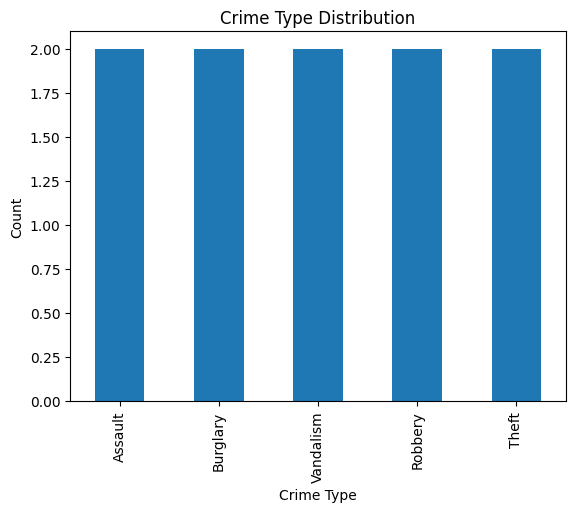

In [51]:
# Cell 5: Summarize crime data
print("Crime Type Distribution:")
print(df['CrimeType'].value_counts())

# Optional: Basic visualization
import matplotlib.pyplot as plt
df['CrimeType'].value_counts().plot(kind='bar')
plt.title('Crime Type Distribution')
plt.xlabel('Crime Type')
plt.ylabel('Count')
plt.show()



In [53]:

# Cell 6: Generate XML for Chicago crime reports without NIEM validation
def chicago_to_niem_xml(json_file, output_dir='niem_chicago_output'):
    os.makedirs(output_dir, exist_ok=True)
    
    try:
        with open(json_file, 'r') as f:
            crime_data = json.load(f)
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {json_file}. Skipping.")
        return
    
    required_fields = ['report_number', 'date_time', 'offense', 'address', 'location_description', 
                      'community', 'beat', 'district', 'status', 'victim', 'suspect', 'iucr_code', 'fbi_code']
    if not all(field in crime_data for field in required_fields):
        print(f"Error: Missing required fields in {json_file}. Skipping.")
        return
    
    root = ET.Element('nc:Incident', {
        'xmlns:nc': 'http://release.niem.gov/niem/niem-core/5.0/',
        'xmlns:j': 'http://release.niem.gov/niem/domains/jxdm/6.0/',
        'xmlns:s': 'http://release.niem.gov/niem/structures/5.0/',
        's:id': escape_xml_text(crime_data['report_number'])
    })

    incident_id = ET.SubElement(root, 'nc:ActivityIdentification')
    id_elem = ET.SubElement(incident_id, 'nc:IdentificationID')
    id_elem.text = escape_xml_text(crime_data['report_number'])
    
    date = ET.SubElement(root, 'nc:ActivityDate')
    date_time = ET.SubElement(date, 'nc:DateTime')
    date_time.text = escape_xml_text(crime_data['date_time'])
    
    category = ET.SubElement(root, 'nc:ActivityCategoryText')
    category.text = escape_xml_text(crime_data['offense'])
    
    offense_meta = ET.SubElement(root, 'nc:ActivityDescriptionText')
    offense_meta.text = escape_xml_text(f"IUCR: {crime_data['iucr_code']}, FBI Code: {crime_data['fbi_code']}")
    
    location = ET.SubElement(root, 'nc:Location')
    address = ET.SubElement(location, 'nc:AddressFullText')
    address.text = escape_xml_text(crime_data['address'])
    loc_desc = ET.SubElement(location, 'nc:LocationDescriptionText')
    loc_desc.text = escape_xml_text(crime_data['location_description'])
    community = ET.SubElement(location, 'nc:LocationArea')
    community_name = ET.SubElement(community, 'nc:AreaName')
    community_name.text = escape_xml_text(crime_data['community'])
    
    le_details = ET.SubElement(root, 'nc:ActivityDescriptionText')
    le_details.text = escape_xml_text(f"Beat: {crime_data['beat']}, District: {crime_data['district']}")
    
    status = ET.SubElement(root, 'nc:ActivityStatus')
    status_text = ET.SubElement(status, 'nc:StatusText')
    status_text.text = escape_xml_text(crime_data['status'])
    
    victim = ET.SubElement(root, 'nc:Person', {'s:id': f"victim-{escape_xml_text(crime_data['report_number'])}"})
    victim_name = ET.SubElement(victim, 'nc:PersonName')
    victim_full_name = ET.SubElement(victim_name, 'nc:PersonFullName')
    victim_full_name.text = escape_xml_text(crime_data['victim'])
    
    victim_assoc = ET.SubElement(root, 'nc:ActivityInvolvedPersonAssociation')
    victim_person_ref = ET.SubElement(victim_assoc, 'nc:PersonReference', {'s:ref': f"victim-{escape_xml_text(crime_data['report_number'])}"})
    victim_role = ET.SubElement(victim_assoc, 'nc:PersonActivityInvolvementText')
    victim_role.text = 'Victim'
    
    suspect = ET.SubElement(root, 'nc:Person', {'s:id': f"suspect-{escape_xml_text(crime_data['report_number'])}"})
    suspect_name = ET.SubElement(suspect, 'nc:PersonName')
    suspect_full_name = ET.SubElement(suspect_name, 'nc:PersonFullName')
    suspect_full_name.text = escape_xml_text(crime_data['suspect'])
    
    suspect_assoc = ET.SubElement(root, 'nc:ActivityInvolvedPersonAssociation')
    suspect_person_ref = ET.SubElement(suspect_assoc, 'nc:PersonReference', {'s:ref': f"suspect-{escape_xml_text(crime_data['report_number'])}"})
    suspect_role = ET.SubElement(suspect_assoc, 'nc:PersonActivityInvolvementText')
    suspect_role.text = 'Suspect'
    
    reporting_official = ET.SubElement(root, 'j:IncidentReportingOfficial')
    official_person = ET.SubElement(reporting_official, 'nc:Person', {'s:id': f"officer-{escape_xml_text(crime_data['report_number'])}"})
    official_name = ET.SubElement(official_person, 'nc:PersonName')
    official_full_name = ET.SubElement(official_name, 'nc:PersonFullName')
    official_full_name.text = escape_xml_text(fake.name())
    
    output_file = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(json_file))[0]}_niem.xml")
    tree = ET.ElementTree(root)
    tree.write(output_file, encoding='utf-8', xml_declaration=True)
    print(f"XML saved as {output_file}")

input_dir = 'chicago_report'
if not os.path.exists(input_dir):
    print(f"Error: Directory {input_dir} not found.")
else:
    json_files = [f for f in os.listdir(input_dir) if f.endswith('.json')]
    if not json_files:
        print(f"No JSON files found in {input_dir}.")
    else:
        for json_file in json_files:
            chicago_to_niem_xml(os.path.join(input_dir, json_file))
        print(f"Processed {len(json_files)} JSON file(s).")

XML saved as niem_chicago_output\chicago_crime_niem.xml
Processed 1 JSON file(s).
